In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [14]:
from core.data_loader import DataLoader
import os
import sys
from core.backtester import Backtester
from strategies.atr_breakout import ATRTrailingBreakout
from strategies.multi_momentum import MultiTimeframeMomentum
from strategies.vwap_reversion import VWAPReversion
from strategies.bb_rsi import BB_RSI
import logging
from datetime import datetime
import pandas as pd

# Налаштування логування
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Завантаження даних
loader = DataLoader()
data_file = 'sol_1h_mrhapr25_askbid.parquet'
if not os.path.exists(os.path.join('data', data_file)):
    logger.info("Завантаження даних...")
    df = loader.fetch_historical_bid_ask('SOLBTC', '1h', start_date='2025-03-01', end_date='2025-05-01')
    loader.save_data({'SOLBTC': df}, data_file)
else:
    df = loader.load_data(data_file)
    df = df['SOLBTC']
data = df['close']
symbol = 'SOLBTC'
df

INFO:__main__:Завантаження даних...


,open,high,low,close,volume,bid,ask
timestamp,,,,,,,
2025-03-01 00:00:00,0.001757,0.001757,0.001736,0.001740,10100.174,0.001740,0.001740
2025-03-01 01:00:00,0.001741,0.001785,0.001735,0.001775,21953.014,0.001775,0.001775
2025-03-01 02:00:00,0.001775,0.001775,0.001718,0.001727,22484.943,0.001727,0.001727
2025-03-01 03:00:00,0.001728,0.001731,0.001708,0.001708,13193.772,0.001708,0.001708
2025-03-01 04:00:00,0.001708,0.001711,0.001690,0.001703,9061.857,0.001702,0.001704
...,...,...,...,...,...,...,...
2025-04-15 06:00:00,0.001534,0.001538,0.001530,0.001534,3149.544,0.001534,0.001535
2025-04-15 07:00:00,0.001535,0.001541,0.001533,0.001535,3572.428,0.001534,0.001535
2025-04-15 08:00:00,0.001535,0.001560,0.001531,0.001534,19924.019,0.001534,0.001534


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf  # Optional - for fetching data

def calculate_bollinger_bands(data, window=20, num_std=2):
    """
    Calculate Bollinger Bands with forward shift to avoid look-ahead bias.
    
    Parameters:
    - data: Pandas Series of closing prices
    - window: Moving average window (typically 20)
    - num_std: Number of standard deviations for the bands (typically 2)
    
    Returns:
    - DataFrame with columns: Middle Band, Upper Band, Lower Band
    """
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    
    # Shift all bands forward by 1 to avoid look-ahead bias
    return pd.DataFrame({
        'Middle Band': rolling_mean.shift(1),
        'Upper Band': upper_band.shift(1),
        'Lower Band': lower_band.shift(1)
    })

# def keep_last_true_in_sequence(series):
#     """
#     Process a boolean Series to keep only the last True in each uninterrupted sequence.
    
#     Args:
#         series: pandas Series of boolean values
        
#     Returns:
#         A new Series with only the last True from each True sequence
#     """
#     # Initialize the result Series with all False
#     result = pd.Series(False, index=series.index)
    
#     # Find the boundaries of True sequences
#     shifted = series.shift(1, fill_value=False)
#     starts = series & ~shifted  # First True in sequence
#     ends = series & ~series.shift(-1, fill_value=False)  # Last True in sequence
    
#     # Keep only the last True in each sequence
#     result[ends] = True
    
#     return result

def identify_crossovers(close_prices, bb_df):
    """
    Identify where price crosses Bollinger Bands.
    
    Returns:
    - DataFrame with crossover signals:
      - 'Upper Cross': Price crosses above upper band
      - 'Lower Cross': Price crosses below lower band
    """
    signals = pd.DataFrame(index=close_prices.index)
    signals['Upper Cross'] = (close_prices > bb_df['Upper Band'])
    signals['Lower Cross'] = (close_prices < bb_df['Lower Band'])
    return signals 

def generate_trading_signals(close_prices, bb_df, signals):
    """
    Generate a DataFrame with clear trading signals and positions.
    """
    trades = pd.DataFrame(index=close_prices.index)
    trades['Price'] = close_prices
    trades = trades.join(bb_df).join(signals)
    
    # Initialize position column
    trades['Position'] = 0
    
    # Generate signals (1 for long, -1 for short)
    trades.loc[trades['Lower Cross'], 'Position'] = 1
    trades.loc[trades['Upper Cross'], 'Position'] = -1
    
    return trades

def plot_bollinger_bands_with_signals(data, bb_df, signals, symbol=''):
    """
    Enhanced plot showing:
    - Price and Bollinger Bands
    - Crossover points
    - Fill between bands
    """
    plt.figure(figsize=(14, 7))
    
    # Plot price and bands
    plt.plot(data.index, data, label='Close Price', color='blue', alpha=0.7, linewidth=1.5)
    plt.plot(bb_df.index, bb_df['Middle Band'], label='Middle Band (SMA)', color='red', linestyle='--')
    plt.plot(bb_df.index, bb_df['Upper Band'], label='Upper Band', color='green', linestyle='-')
    plt.plot(bb_df.index, bb_df['Lower Band'], label='Lower Band', color='green', linestyle='-')
    
    # Fill between bands
    plt.fill_between(bb_df.index, bb_df['Upper Band'], bb_df['Lower Band'], color='gray', alpha=0.1)
    
    # Plot crossover signals
    upper_crosses = signals[signals['Upper Cross']].index
    lower_crosses = signals[signals['Lower Cross']].index
    
    plt.scatter(upper_crosses, data[upper_crosses], 
               color='red', marker='v', s=100, label='Upper Band Cross (Sell Signal)')
    plt.scatter(lower_crosses, data[lower_crosses], 
               color='green', marker='^', s=100, label='Lower Band Cross (Buy Signal)')
    
    plt.title(f'Bollinger Bands with Trading Signals - {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

Optimizing parameters: 100%|██████████| 680/680 [01:42<00:00,  6.66it/s]



Optimal Parameters - Window: 16, Std: 2.10

Performance Metrics with Optimal Parameters:
Start                         2025-03-01 00:00:00
End                           2025-04-15 10:00:00
Period                           45 days 11:00:00
Start Value                                 100.0
End Value                              117.267752
Total Return [%]                        17.267752
Benchmark Return [%]                   -10.579852
Max Gross Exposure [%]                      100.0
Total Fees Paid                           4.40554
Max Drawdown [%]                        15.348538
Max Drawdown Duration            39 days 20:00:00
Total Trades                                   21
Total Closed Trades                            20
Total Open Trades                               1
Open Trade PnL                           1.434244
Win Rate [%]                                 60.0
Best Trade [%]                           9.566822
Worst Trade [%]                         -6.742142
Avg Winnin

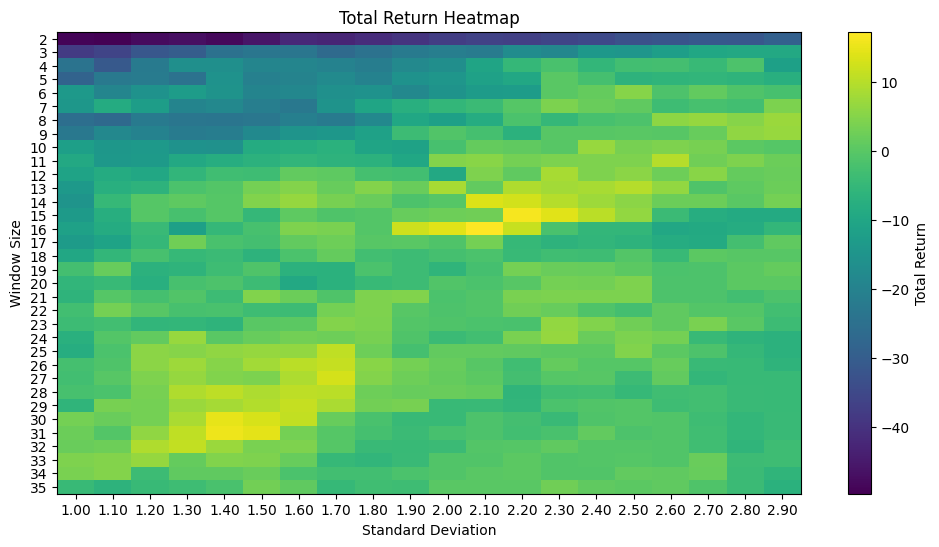

In [16]:
import numpy as np
import pandas as pd
import vectorbt as vbt
import yfinance as yf
from matplotlib import pyplot as plt

def optimize_bollinger_bands(close_price, window_range, std_range):
    """
    Optimize Bollinger Bands parameters using explicit for loops.
    
    Args:
        close_price: Series of close prices
        window_range: Range of window sizes to test (e.g., range(10, 50, 5))
        std_range: Range of standard deviations to test (e.g., np.arange(1.5, 3.0, 0.25))
    
    Returns:
        A tuple of (optimal_window, optimal_std, results_df, best_pf)
        where results_df contains performance metrics for all combinations
    """
    # Initialize storage for results
    results = []
    
    # Progress bar
    total_combinations = len(window_range) * len(std_range)
    progress_bar = tqdm(total=total_combinations, desc="Optimizing parameters")
    
    for window in window_range:
        for std in std_range:

            # Calculate Bollinger Bands
            # bb_df = calculate_bollinger_bands(close_price, window, std)
            bb = vbt.BBANDS.run(close_price, window=window, alpha=std)
            
            # Generate signals
            # signals = identify_crossovers(close_price, bb_df)
            # entries = close_price.vbt.crossed_above(bb_df['Lower Band'])
            # exits = close_price.vbt.crossed_below(bb_df['Upper Band'])
            entries = close_price.vbt.crossed_above(bb.lower.shift(1))
            exits = close_price.vbt.crossed_below(bb.upper.shift(1))
                        
            # Replace original entries with filtered version
            entries = filtered_entries
            
            # Run backtest
            pf = vbt.Portfolio.from_signals(
                close_price,
                entries, exits,
                # signals['Lower Cross'], signals['Upper Cross'],
                fees=0.001,  # 0.1% fee per trade
                slippage=0.001,  # 0.1% slippage per trade
                freq='1h',
            )
            
            # Store results
            stats = pf.stats()
            results.append({
                'window': window,
                'std': std,
                'total_return': stats['Total Return [%]'],
                'sharpe_ratio': stats['Sharpe Ratio'],
                'win_rate': stats['Win Rate [%]'],
                'profit_factor': stats['Profit Factor'],
                'trades': stats['Total Trades'],
                'portfolio': pf  # Store the portfolio object for the best one later
            })
            
            progress_bar.update(1)
    
    progress_bar.close()
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Find best parameters based on Sharpe ratio
    best_idx = results_df['total_return'].idxmax()
    best_window = results_df.loc[best_idx, 'window']
    best_std = results_df.loc[best_idx, 'std']
    best_pf = results_df.loc[best_idx, 'portfolio']
    
    return best_window, best_std, results_df, best_pf

# Parameter ranges to test
window_range = range(2, 36, 1)  # From 10 to 50 in steps of 5
std_range = np.arange(1., 3.0, 0.1)  # From 1.5 to 3.0 in steps of 0.25

# Run optimization
best_window, best_std, results_df, best_pf = optimize_bollinger_bands(
    data, window_range, std_range
)

print(f"\nOptimal Parameters - Window: {best_window}, Std: {best_std:.2f}")
print("\nPerformance Metrics with Optimal Parameters:")
print(best_pf.stats())

# Plot heatmap of Total Return
pivot_table = results_df.pivot(index='window', columns='std', values='total_return')
plt.figure(figsize=(12, 6))
plt.title('Total Return Heatmap')
plt.xlabel('Standard Deviation')
plt.ylabel('Window Size')
plt.imshow(pivot_table, cmap='viridis', aspect='auto')
plt.colorbar(label='Total Return')
plt.xticks(range(len(std_range)), [f"{s:.2f}" for s in std_range])
plt.yticks(range(len(window_range)), window_range)
plt.show()

In [17]:
best_pf.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'e88b030f-aad7-41fb-a05f-1e23675bdfb3',
              'x': array([datetime.datetime(2025, 3, 1, 0, 0),
                          datetime.datetime(2025, 3, 1, 1, 0),
                          datetime.datetime(2025, 3, 1, 2, 0), ...,
                          datetime.datetime(2025, 4, 15, 8, 0),
                          datetime.datetime(2025, 4, 15, 9, 0),
                          datetime.datetime(2025, 4, 15, 10, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([0.0017401, 0.0017747, 0.0017272, ..., 0.0015342, 0.0015527, 0.001556 ]),
              'yaxis': 'y'},
             {'customdata': array([[0.00000000e+00, 6.03533500e+04, 9.99000999e-02],
                                   [2.00000000e+00, 6.27768723e+04, 1.09447817e-01],
                   

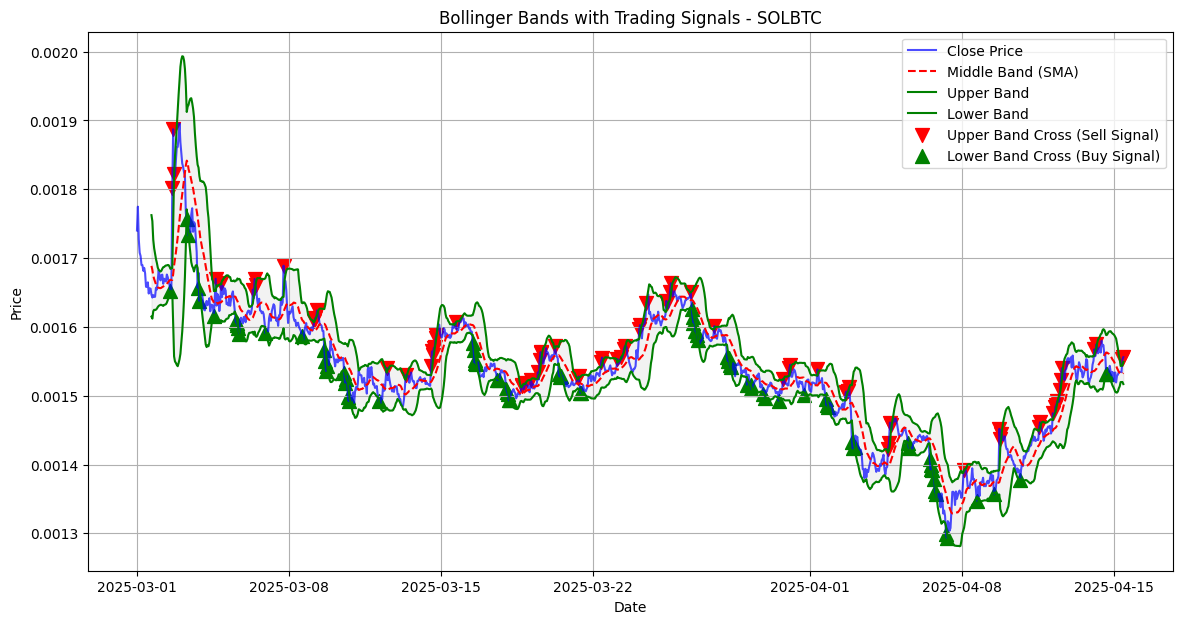

In [18]:
bb_df = calculate_bollinger_bands(data, best_window, best_std)
signals = identify_crossovers(data, bb_df)
trades = generate_trading_signals(data, bb_df, signals)

# Print some trading signals
# print("Sample Trading Signals:")
# print(trades[trades['Position'] != 0].head(10))

# Plot with signals
plot_bollinger_bands_with_signals(data, bb_df, signals, symbol)

In [19]:
entries = data.vbt.crossed_above(bb_df['Lower Band'])
exits = data.vbt.crossed_below(bb_df['Upper Band'])

pf = vbt.Portfolio.from_signals(
    data,
    entries, exits,
    # signals['Lower Cross'], signals['Upper Cross'],
    fees=0.001,  # 0.1% fee per trade
    slippage=0.001,  # 0.1% slippage per trade
    freq='1h',
)
pf.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'name': 'Close',
              'showlegend': True,
              'type': 'scatter',
              'uid': '92edbaf3-ba17-4333-ad67-25c90a54d780',
              'x': array([datetime.datetime(2025, 3, 1, 0, 0),
                          datetime.datetime(2025, 3, 1, 1, 0),
                          datetime.datetime(2025, 3, 1, 2, 0), ...,
                          datetime.datetime(2025, 4, 15, 8, 0),
                          datetime.datetime(2025, 4, 15, 9, 0),
                          datetime.datetime(2025, 4, 15, 10, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([0.0017401, 0.0017747, 0.0017272, ..., 0.0015342, 0.0015527, 0.001556 ]),
              'yaxis': 'y'},
             {'customdata': array([[0.00000000e+00, 6.03533500e+04, 9.99000999e-02],
                                   [2.00000000e+00, 6.27768723e+04, 1.09447817e-01],
                   

In [20]:
pf.stats()

Start                         2025-03-01 00:00:00
End                           2025-04-15 10:00:00
Period                           45 days 11:00:00
Start Value                                 100.0
End Value                              110.172294
Total Return [%]                        10.172294
Benchmark Return [%]                   -10.579852
Max Gross Exposure [%]                      100.0
Total Fees Paid                          3.631199
Max Drawdown [%]                        19.169179
Max Drawdown Duration            43 days 18:00:00
Total Trades                                   18
Total Closed Trades                            17
Total Open Trades                               1
Open Trade PnL                           1.347463
Win Rate [%]                            52.941176
Best Trade [%]                           9.566822
Worst Trade [%]                         -6.742142
Avg Winning Trade [%]                    3.293734
Avg Losing Trade [%]                    -2.497899
